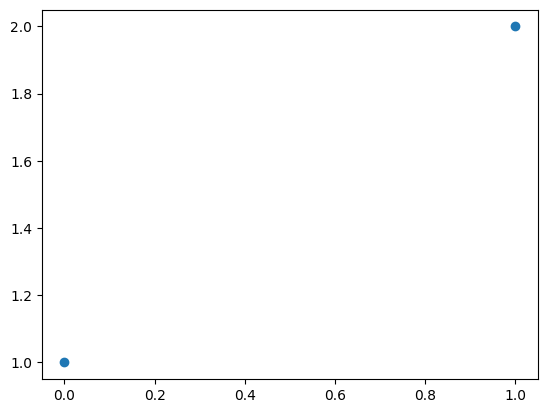

In [1]:
import sys
sys.path.append('f:/seismic/code/core')
sys.path.append('/seismic/code/core')
sys.path.append('/kaggle/input/my-seis-library/')
import kaggle_support as kgs
import importlib
import numpy as np
import matplotlib.pyplot as plt
import glob
import copy
import os
import seis_forward
import seis_test
import cupy as cp
plt.scatter([0,1],[1,2])
#fls.download_kaggle_dataset('jeroencottaar/byu-many-models-2/', fls.result_dir + '/many_full_res/')

10000
Style_A


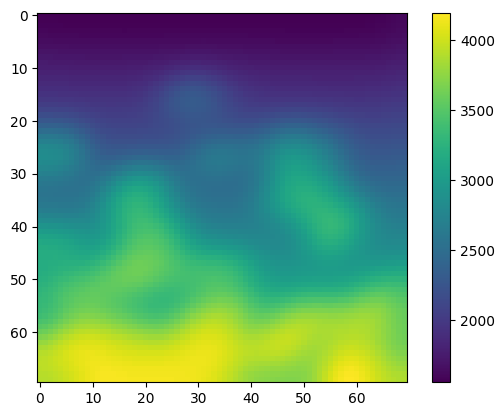

In [109]:
importlib.reload(kgs)
importlib.reload(seis_forward)
data=kgs.load_all_train_data()
print(len(data))
for d in data:
    d.check_constraints()
d = data[8364]
print(d.family)
d.load_to_memory()
plt.figure()
plt.imshow(cp.asnumpy(d.velocity.data));plt.colorbar();#plt.clim([-3,3])

In [44]:
# for i in np.arange(10000)[::10]:
#     d = data[i]
#     #print(d.family)
#     d.load_to_memory()
#     vals = np.linspace(0.99,1.01,10)
#     res = []
#     for v in vals:
#         dd = copy.deepcopy(d)
#         dd.velocity.min_vel *=v
#         res.append(kgs.rms(dd.seismogram.data - seis_forward.vel_to_seis(dd.velocity, dd.seismogram)[0].data))
#     plt.figure()
#     plt.plot(vals*cp.asnumpy(dd.velocity.min_vel),cp.asnumpy(cp.array(res)))    
#     plt.title(i)
#     plt.pause(0.0001)

In [45]:
cp.unique(d.velocity.data)

array([1562., 1591., 1950., 2315., 2897., 3179., 3264.])

In [46]:
import scipy
mat = cp.asnumpy(d.velocity.data)
basis_vectors = []
for val in np.unique(mat):
    this_mat = (mat==val)
    basis_vectors.append(np.concatenate((this_mat.flatten(), np.array([0]))))
diff = np.diff(np.mean(mat,axis=1))
# for ii in range(len(diff)):
#     if diff[ii]>1.:
#         for jj in np.arange(ii-1,ii+2):
#             this_mat = 0*mat
#             this_mat[jj,:] = 1
#             basis_vectors.append(np.concatenate((this_mat.flatten(), np.array([0]))))
basis_vectors.append(np.concatenate((0*this_mat.flatten(), np.array([1]))))   
basis_vectors = np.stack(basis_vectors)
basis_vectors = basis_vectors.T
basis_vectors=cp.array(basis_vectors)
basis_vectors.shape

(4901, 8)

In [47]:
# for ii in range(10):#basis_vectors.shape[1]):
#     vec = basis_vectors[:,ii]
#     vel = copy.deepcopy(d.velocity)
#     vel.from_vector(vec)
#     plt.figure()
#     plt.imshow(cp.asnumpy(vel.data));plt.colorbar();#plt.clim([-3,3])
#     plt.title(ii)

In [48]:
J_basis = seis_forward.vel_to_seis_diff(d.velocity, basis_vectors.T).T

Text(0.5, 1.0, 'basis')

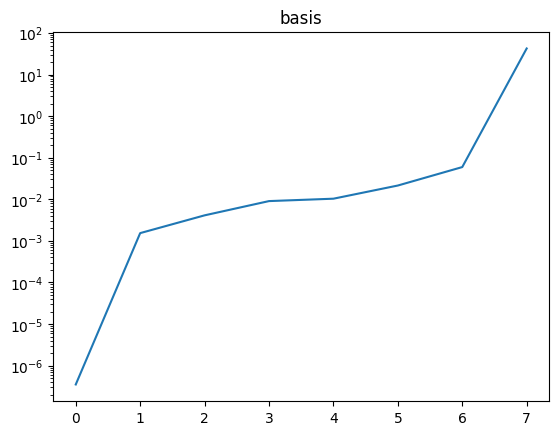

In [49]:
X = J_basis.T@J_basis
w = cp.linalg.eigvalsh(X)   
plt.figure()
plt.semilogy(cp.asnumpy(cp.abs(w)))
plt.title('basis')

In [50]:
d.velocity.to_vector()

array([1591., 1591., 1591., ..., 1562., 1562., 1562.])

In [51]:
kgs.profiling=False
seis_base_recalc = seis_forward.vel_to_seis(d.velocity, d.seismogram)[0]
basis_offset_vector = 10*cp.array(np.random.default_rng(seed=0).normal(0,1,(basis_vectors.shape[1],1)), dtype=kgs.base_type_gpu)
#basis_offset_vector[:-1]=0
vel_offset_vector = basis_vectors@(basis_offset_vector)
vel_modified = copy.deepcopy(d.velocity)
vel_modified.from_vector(d.velocity.to_vector() + vel_offset_vector[:,0])
seis_modified = seis_forward.vel_to_seis(vel_modified, d.seismogram)[0]
seis_modified_vector = seis_modified.to_vector()
seis_modified_linear = copy.deepcopy(d.seismogram)
seis_modified_linear.from_vector(seis_base_recalc.to_vector() + (J_basis@basis_offset_vector)[:,0])
#kgs.rms(seis_modified_vector - seis_base_recalc.to_vector() - seis_forward.vel_to_seis_diff(d.velocity, vel_offset_vector.T)), kgs.rms(seis_modified_vector - seis_base_recalc.to_vector())
kgs.rms(seis_modified_vector - seis_base_recalc.to_vector() - (J_basis@basis_offset_vector)[:,0]), kgs.rms(seis_modified_linear.to_vector() - seis_base_recalc.to_vector() - (J_basis@basis_offset_vector)[:,0]), kgs.rms(seis_modified_vector - seis_base_recalc.to_vector())

(array(0.00020288), array(7.67628739e-17), array(0.01466867))

In [52]:
P=cp.eye(J_basis.shape[1], dtype=J_basis.dtype)
#PP=cp.diag(1*np.ones(J_basis.shape[1]-1),k=-1)+cp.diag(1*np.ones(J_basis.shape[1]-1),k=1)-2*cp.eye(J_basis.shape[1])
# PP = PP[1:-1,:]
# PP=cp.diag(1*np.ones(J_basis.shape[1]-1),k=1)-1*cp.eye(J_basis.shape[1])
# PP = PP[:-1,:]
# PP = PP.T@PP
# #print(PP.shape)
# #plt.imshow(cp.asnumpy(PP))
# P = PP
def analyze_one(velocity_guess, velocity_true, seismogram_for_guess, seismogram_true_given, J_basis, lambda_vals):
    print('starting')
    s0 = seismogram_true_given.to_vector()[:,None]
    s1 = seismogram_for_guess.to_vector()[:,None]
    v1 = velocity_guess.to_vector()[:,None]
    v_base = cp.linalg.solve(basis_vectors.T@basis_vectors, basis_vectors.T@v1)

    res = []
    v0_list = []
    rhs_part = (J_basis.T@(s0-s1))
    #return
    for lam in lambda_vals:
        #print(P.shape, v_base.shape,rhs_part.shape,J_basis.shape)
        rhs=rhs_part-lam*P@v_base
        delta_v = cp.linalg.solve(lam*P+(J_basis.T@J_basis),rhs)        
        v0 = v1+basis_vectors@delta_v
        v0_list.append(v0)
        #res.append(kgs.rms(v0-velocity_true.to_vector()[:,None]))
        dd=v0-velocity_true.to_vector()[:,None]
        res.append(kgs.rms(dd[:-1]))
        #print(kgs.rms(dd), cp.max(dd[:-1]), cp.min(dd[:-1]), dd[-1])
        
            
        #print(lam,penalty(v0),penalty(velocity_true.to_vector()[:,None]))

    return cp.asnumpy(cp.array(res)), v0_list

starting
starting
starting
starting
0.24632817100044907


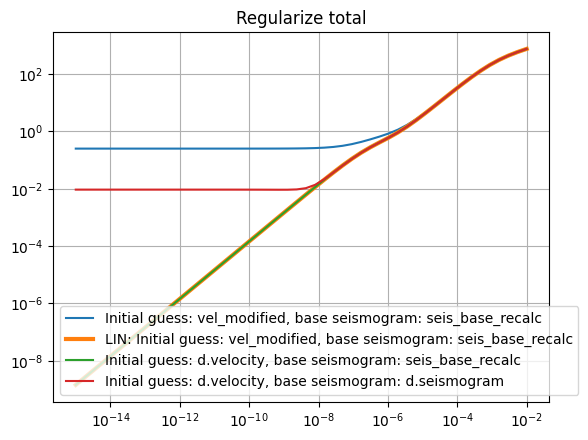

In [53]:
# So we get access to vel_modified (and seis_modified) and seis_base_recalc, and are asked to reconstruct vel_base.
lambda_vals = 10**np.linspace(-15,-2,50)

res1,v0_list = analyze_one(vel_modified, d.velocity, seis_modified, seis_base_recalc, J_basis, lambda_vals)
res2,v0_list = analyze_one(vel_modified, d.velocity, seis_modified_linear, seis_base_recalc, J_basis, lambda_vals)
res3,v0_list = analyze_one(d.velocity, d.velocity, seis_base_recalc, seis_base_recalc, J_basis, lambda_vals)
res4,v0_list = analyze_one(d.velocity, d.velocity,seis_base_recalc, d.seismogram, J_basis, lambda_vals)
#res4,v0_list = analyze_one(vel_modified, d.velocity, seis_modified, seis_base_recalc, J_basis, lambda_vals)

# #lambda_vals = [1e-6]
# res=[]
# v0_list=[]
# rhs_part = J_basis.T@(s0-s1)
# for lam in lambda_vals:
#     rhs=rhs_part-lam*v_base
#     delta_v = cp.linalg.solve(lam*cp.eye(J_basis.shape[1], dtype=J_basis.dtype)+J_basis.T@J_basis,rhs)
#     v0 = v1+basis_vectors@delta_v
#     v0_list.append(v0)
#     res.append(kgs.rms(v0-d.velocity.to_vector()[:,None]))
# res = cp.asnumpy(cp.array(res))
plt.loglog(lambda_vals,res1)
plt.loglog(lambda_vals,res2,linewidth=3)
plt.loglog(lambda_vals,res3)
plt.loglog(lambda_vals,res4)
plt.grid(True)
plt.title('Regularize total')
plt.legend(('Initial guess: vel_modified, base seismogram: seis_base_recalc', 'LIN: Initial guess: vel_modified, base seismogram: seis_base_recalc', 'Initial guess: d.velocity, base seismogram: seis_base_recalc', 'Initial guess: d.velocity, base seismogram: d.seismogram'))
print(np.min(res1))

In [54]:
print(seis_base_recalc.data[0,0,0])
print(d.seismogram.data[0,0,0])
print(kgs.rms(seis_base_recalc.data-d.seismogram.data))
print(kgs.rms(seis_base_recalc.to_vector()[:,None]-d.seismogram.to_vector()[:,None]))
res = seis_base_recalc.to_vector()[:,None]-d.seismogram.to_vector()[:,None]
print(res.T@res)

-0.0004162471806976144
-0.00041624720324762166
5.2945377883133986e-05
5.2945377883133986e-05
[[0.00098014]]


[[45707042.87227973]] 3.809712233891068e-05
[[45725040.]] 5.2945377883133986e-05


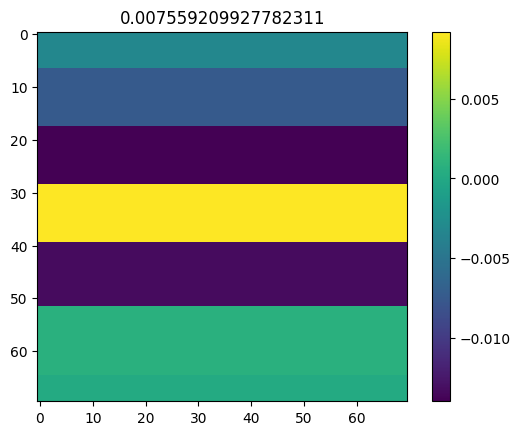

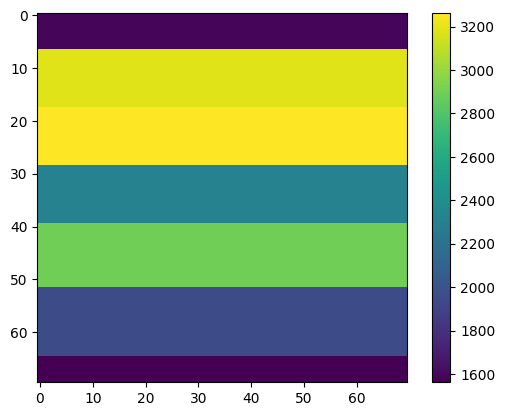

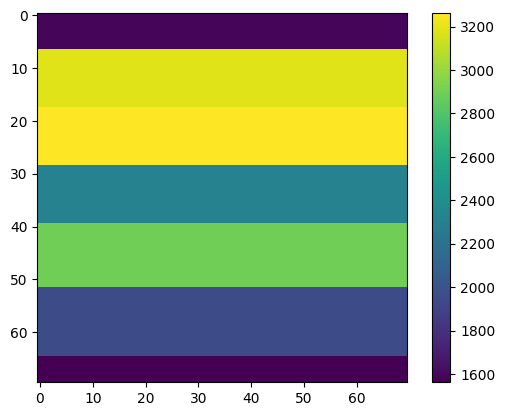

In [55]:
def show_penalty(v):    
    vel_new = copy.deepcopy(d.velocity)
    vel_new.from_vector(v[:,0])
    seis = seis_forward.vel_to_seis(vel_new, d.seismogram)[0]
    res = (seis.to_vector()[:,None]-d.seismogram.to_vector()[:,None])
    #penalty = (lam*v.T@v + res.T@res)[0,0]
    v_base = cp.linalg.solve(basis_vectors.T@basis_vectors, basis_vectors.T@v)
    print(v_base.T@P@v_base, kgs.rms(res))
    #return penalty
    
to_take = np.argmin(res4)
to_take=0
v0 = v0_list[to_take]
plt.figure()
vel_new = copy.deepcopy(d.velocity)
vel_new.from_vector(v0[:,0])
plt.title(cp.mean(cp.abs(vel_new.data-d.velocity.data)))
plt.imshow(cp.asnumpy(vel_new.data-d.velocity.data));plt.colorbar();#plt.clim([-3,3])
show_penalty(v0)
show_penalty(d.velocity.to_vector()[:,None])
plt.figure()
plt.imshow(cp.asnumpy(d.velocity.data));plt.colorbar();#plt.clim([-3,3])
plt.figure()
plt.imshow(cp.asnumpy(vel_new.data));plt.colorbar();#plt.clim([-3,3])
#plt.figure()
#plt.title(cp.mean(cp.abs(vel_modified.data-d.velocity.data)))
#plt.imshow(cp.asnumpy(vel_modified.data-d.velocity.data));plt.colorbar();#plt.clim([-3,3])
#print(kgs.rms(seis_modified.data-seis_base_recalc.data), kgs.rms(d.seismogram.data-seis_base_recalc.data))
#print(kgs.rms(vel_modified.data-d.velocity.data), kgs.rms(seis_forward.vel_to_seis(vel_modified, d.seismogram)[0].data-seis_forward.vel_to_seis(d.velocity, d.seismogram)[0].data))
#print(kgs.rms(vel_new.data-d.velocity.data), kgs.rms(seis_forward.vel_to_seis(vel_new, d.seismogram)[0].data-seis_forward.vel_to_seis(d.velocity, d.seismogram)[0].data))

(10495841.0, 10498357.829173997)

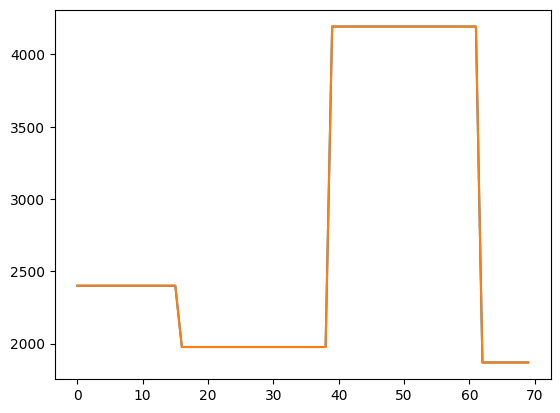

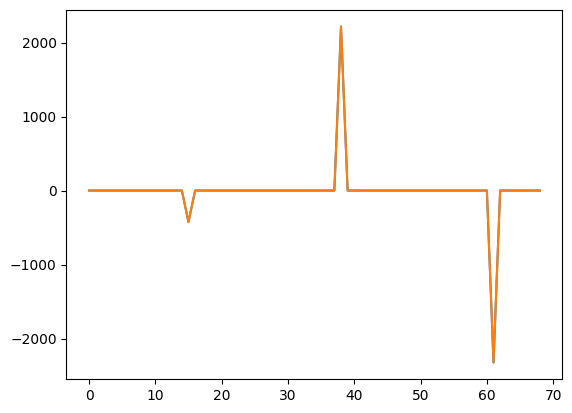

In [15]:
plt.figure()
plt.plot(cp.asnumpy(cp.mean(d.velocity.data,axis=1)))
plt.plot(cp.asnumpy(cp.mean(vel_new.data,axis=1)))
plt.figure()
plt.plot(np.diff(cp.asnumpy(cp.mean(d.velocity.data,axis=1))))
plt.plot(np.diff(cp.asnumpy(cp.mean(vel_new.data,axis=1))))
np.sum(np.diff(cp.asnumpy(cp.mean(d.velocity.data,axis=1)))**2),np.sum(np.diff(cp.asnumpy(cp.mean(vel_new.data,axis=1)))**2)